### Reading the data file using `numpy.loadtxt()` function & Plotting `numpy.log10(image)` using the `matplotlib.pyplot.matshow()`

14641

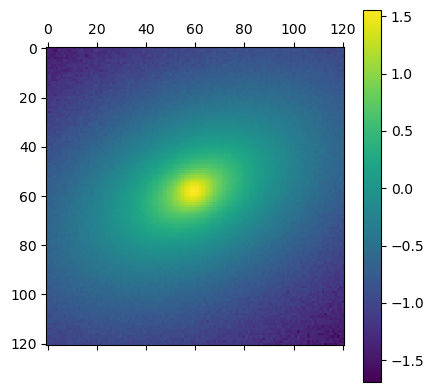

In [1]:
import numpy as np
import matplotlib.pyplot as plt

image = np.loadtxt('/Users/milie/Documents/Project BDLensing/team_3_order_3 (2).txt')

plt.matshow(np.log10(image))
plt.colorbar()


np.size(image)

## Plotting the signal to ratio map

[[5.06848182 4.72224955 4.38514869 ... 7.68172543 8.01925191 8.42648131]
 [5.05329305 4.97647528 4.94243722 ... 8.01258836 7.85775857 8.60324052]
 [4.85351379 4.94856544 5.01924275 ... 8.67982688 8.56236944 8.43066482]
 ...
 [7.25108315 7.39216995 8.11217129 ... 5.03540436 4.33192205 4.0522433 ]
 [7.91974251 7.90982455 7.70056756 ... 4.68918095 4.05580008 4.28292063]
 [7.59741083 7.54746951 7.20418927 ... 4.65702165 4.8678513  4.91341345]]
[[5.06848182 4.72224955 4.38514869 ... 7.68172543 8.01925191 8.42648131]
 [5.05329305 4.97647528 4.94243722 ... 8.01258836 7.85775857 8.60324052]
 [4.85351379 4.94856544 5.01924275 ... 8.67982688 8.56236944 8.43066482]
 ...
 [7.25108315 7.39216995 8.11217129 ... 5.03540436 4.33192205 4.0522433 ]
 [7.91974251 7.90982455 7.70056756 ... 4.68918095 4.05580008 4.28292063]
 [7.59741083 7.54746951 7.20418927 ... 4.65702165 4.8678513  4.91341345]]


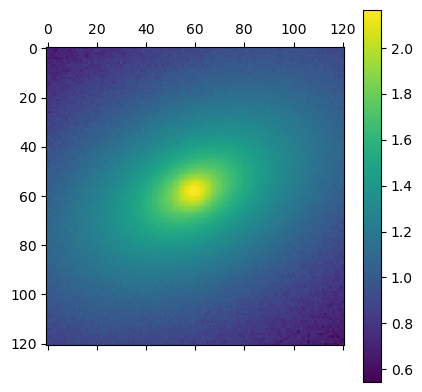

In [2]:
exposure_time = 600
mean_value = image * exposure_time
noise_level = np.sqrt(mean_value)
print(noise_level)

snr = image / (noise_level / exposure_time)
print(snr)

plt.matshow(np.log10(snr))
plt.colorbar()

# likelihood mask

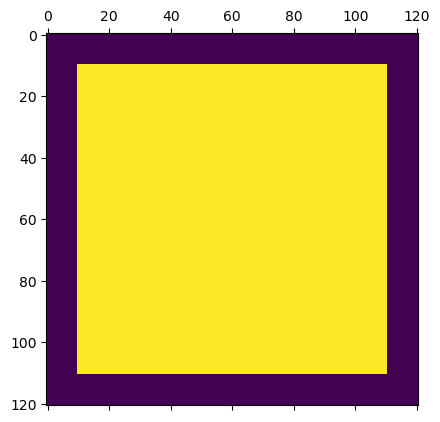

In [3]:
mask = np.zeros_like(image)

mask[10:-10, 10:-10] = 1

plt.matshow(mask)

## Sersic Light Profile

In [4]:
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.modeling.models import Sersic2D
from numpy import sqrt 

def get_sersic_2d(amp, r_eff, x_0, y_0, q, phi):

    x,y = np.meshgrid(np.arange(121), np.arange(121))

    model_sersic_2d = Sersic2D(amplitude=amp, 
                               r_eff= r_eff / 0.05, 
                               x_0=x_0 / 0.05, 
                               y_0=y_0 / 0.05, 
                               ellip=1-q, 
                               theta=phi)
    
    sersic_image = model_sersic_2d(x, y)
    
    psf_size = 6/2.335
    
    psf = Gaussian2DKernel(psf_size)
    
    convolved_image = convolve(sersic_image, psf)
    
    return convolved_image

def get_log_likelihood(params):
    """
    Compute the log likelihood value.
    :param params: array containing model parameters
    :type params: np.array
    :return: log likelihood value
    :rtype: float
    """
    # write code
    amp, r_eff, x_0, y_0, q, phi = params
    
    sigma = noise_level / 600
    
    convolved_image = get_sersic_2d(amp, r_eff, x_0, y_0, q, phi)
    
    return -0.5 * np.sum(((image - convolved_image) ** 2 / sigma**2) * mask)


def get_log_prior(params):
    """
    Get the log prior value.
    :param params: array containing model parameters
    :type params: np.array
    :return: log prior value
    :rtype: float
    """
    # write code
    
    amp, r_eff, x_0, y_0, q, phi = params
    
    if not 0. < x_0 < 6.:
        return -np.inf
    
    if not 0. < y_0 < 6.:
        return -np.inf
    
    if not 0.4 < q < 1.0:
        return -np.inf
    
    if not 0 < phi < np.pi:
        return -np.inf
    
    if not 0.0 < amp:
        return -np.inf
    
    if not 0.0 < r_eff < 4.0:
        return -np.inf
    
    return 0.
    


def get_log_posterior(params):
    """
    Compute the log posterior value.
    :param params: array containing model parameters
    :type params: np.array
    :return: log posterior value
    :rtype: float
    """
    
    amp, r_eff, x_0, y_0, q, phi = params
    
    log_prior = get_log_prior(params)

    if np.isinf(log_prior):
        return -np.inf
    else:
        return get_log_likelihood(params) + log_prior

# MCMC 

In [5]:
import emcee # import the emcee package

init_params = np.array([1.31, 1.41, 2.97, 2.89, 0.600, 2.6900])
num_step = 1000
num_walkers = 40
num_params = len(init_params)
init_walker_positions = np.random.normal(loc=init_params, scale=1e-4,
                                        size=(num_walkers, num_params))

sampler = emcee.EnsembleSampler(num_walkers, num_params,
                                get_log_posterior)

sampler.run_mcmc(init_walker_positions, num_step, progress=True);

100%|███████████████████████████████████████| 1000/1000 [05:11<00:00,  3.21it/s]


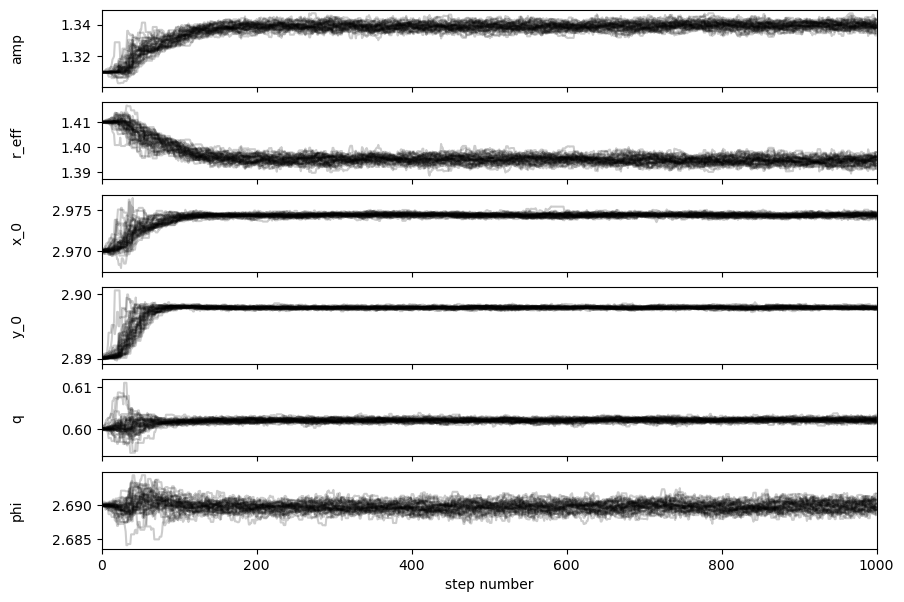

In [6]:
fig, axes = plt.subplots(num_params, figsize=(10, 7), sharex=True)

samples = sampler.get_chain()
labels = ['amp', 'r_eff', 'x_0', 'y_0', 'q', 'phi'] # make a list of strings for the labels of your model parameters

for i in range(num_params):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.2)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [7]:
from IPython.display import display, Math

discard = 200
flat_samples = sampler.get_chain(discard=discard, thin=1, flat=True)

for i in range(num_params):
    percentile_16, median, percentile_84 = np.percentile(
        flat_samples[:, i], [16, 50, 84])

    text = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{+{2:.4f}}}"
    text = text.format(median,
                       median - percentile_16,
                       percentile_84 - median,
                       labels[i])
    display(Math(text))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

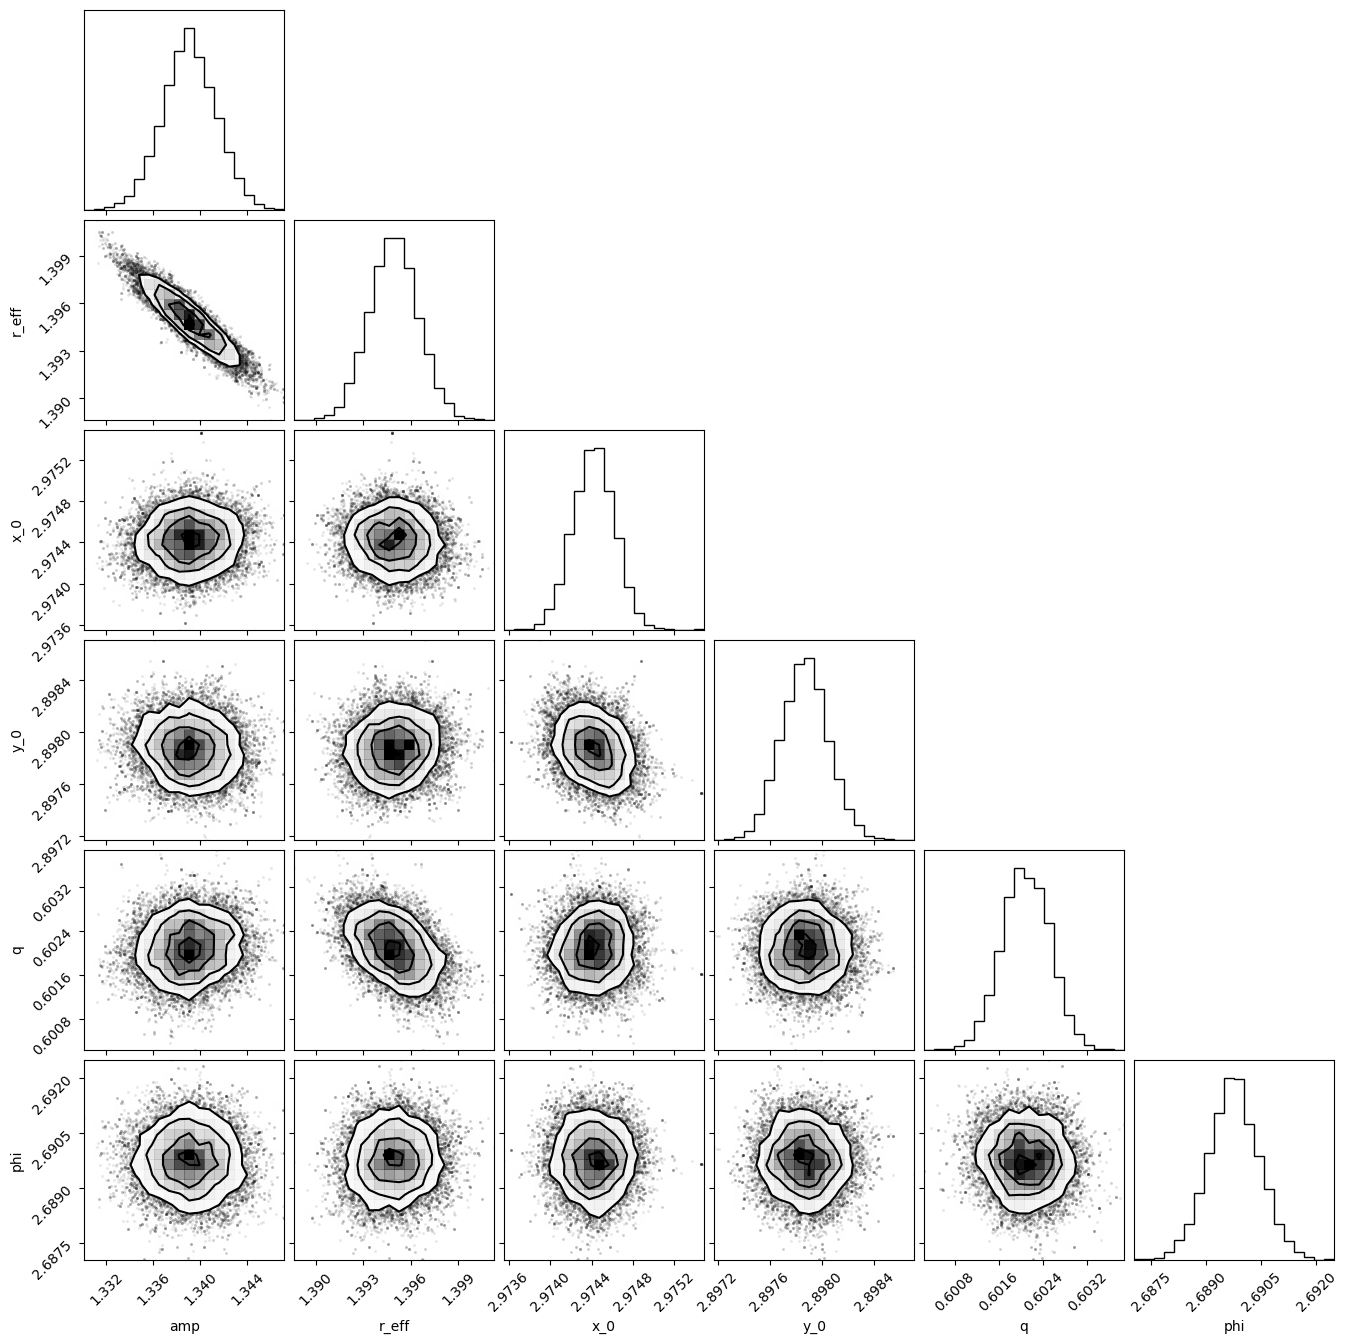

In [8]:
import corner

corner.corner(flat_samples, labels=labels);

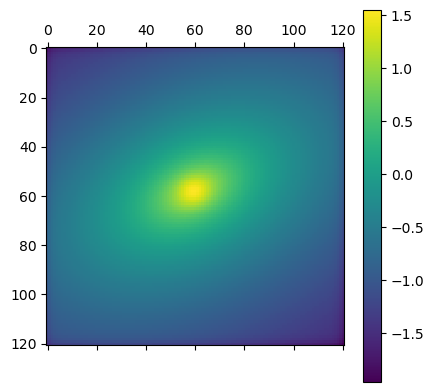

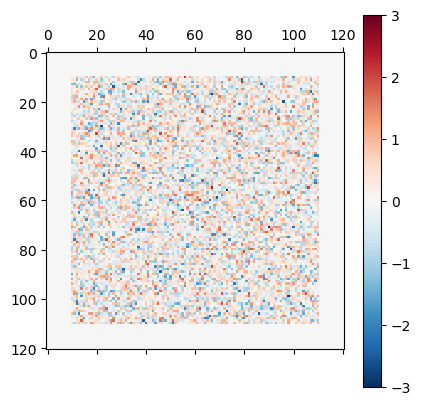

In [9]:
best_fit_params = np.median(flat_samples, axis=0)

best_fit_image = get_sersic_2d(*best_fit_params)

plt.matshow(np.log10(best_fit_image))
plt.colorbar()
plt.show()


plt.matshow(((image - best_fit_image) / (noise_level/600)) * mask, cmap='RdBu_r', vmax = 3, vmin = -3)
plt.colorbar()
plt.show()

## chi^2 & Reduced chi^2 

In [10]:
chi_square = np.sum(((image - best_fit_image) / (noise_level/600)) ** 2)

reduced_chi_square = chi_square / (np.size(image) - num_params)

print(chi_square)
print(reduced_chi_square)

16964.533068400026
1.159175474437993


# Value of R_sersic


In [11]:
from numpy import sqrt

q = 0.6021
r_eff = 1.3950
r_sersic = sqrt(q) * r_eff

r_sersic

1.082451685988802